# FACT Bias crate current measurement resolution

D. Neise 28.07.2017

There is a slight mistake in the documentation of the Bias crate. For example in "GAPDHV2CurrentMeasurement.pdf" it says: 

    10 counts equal ~12 μA
    
Or in "GAPDBiasSupplyV0222022010.pdf" where it says:

    An individual current measurement is implemented for each single channel with a 12-bit resolution, which practically results in a 1% accuracy due to the channel regulation noise effects. 
    
Here is does say "12-bit resolution" but it does not specify the full scale. But elsewhere is says:

    Imax = 5mA/channel
    
So altogether it makes sense, that people assume there is a 12-bit ADC, with a 5mA full scale, resulting in a resolution of 5mA / 4096 steps = 1.2 µA/step or 1.2 µA/LSB. (LSB = least significant bit)

However this is *not quite right* ... not quite? ... well yes.

----

## The schematic: 12bit & 10mA

If you look at the schematic, you see the current **I** is measured as a voltage drop over a resistor **R8=100$\Omega$**. This differential voltage over the resistor is then referenced to GND with a gain of 1, so voltage over resistor is now voltage above GND (done by HV7800). Then it is aplified with a normal non-inverting op-amp with a gain **G=5**. The resulting amplified voltage is fed into an ADC with 12bit resolution and a V$_{ref}$ = 5V, thus it has a resolution of **$U_{step} \approx$ 1.2mV/LSB**

Putting all the bold printed numbers together, we get the resolution of the "current measuring ADC" which is formed by these 4 parts working together.

$ I_{step} = U_{step} / (G \cdot R8) \approx 1.2mV/500\Omega \approx 2.4µA$

Or if we rather like to look at the full scale, than the step: $I_{FS} = I_{step} \cdot 4096 = 10mA$

This contradicts the statement from "GAPDHV2CurrentMeasurement.pdf", if there was not ...

## The firmware: 12bit(?) & 5mA

The schematic can easily lie ... there could be a different resistor placed on the board, than was planned in the schematic, such last minute changes are not unheared of. Of course I checked this very carefully, when I first found this contradiction between the prose documentation and the schematic and found everything to be on the board exactly as it was mentioned in the schematic. (Well .. apart from the additional 1k$\Omega$ at the output, but this has no impact in this discussion)

So I conducted a test, which was not quickly done ... I can tell you, it took much longer to conduct, that it takes you to read this document, so please pardon its length.

I set up a single channel to output a known voltage and attached a know load. The total current (i.e. the "control current" and the "output current") flowing through **R8=100$\Omega$** was **I$\approx 345$µA$**.

To make sure I was doing everything correctly, I measured:

 $U_{R8} = R8 \cdot  I \approx 35mV$
 
And then after the G=5 amplification:

 $U_{ADC} = R8 \cdot I \cdot G \approx 209mV$
 
And then I actually looked with a scope at the outout of the ADC:

![SCLK_DATA_and_CS_annotated](SCLK_DATA_and_CS_annotated.png)

As you can see, the output was **adc=171 LSB** .. which is very close to the expected 209mV. Also from this number we can calculate:

$I_{step} = I / adc \approx 345µA / 171LSB \approx 2µA/LSB$

This is not exactly the expected result, but close. Now .. that we know the ADC outputs 171 under these conditions, I had look what the bias crate controller sends to the PC.

![bias_crate_output_annotated](bias_crate_output_annotated.png)

This image is a bit crowded, so:

* column[0] left : 3 bytes (24bit) coming from crate controller
* column[1] : only the 12 bits, which should be the ADC output
* column[2] : the same 12bit converted to hex
* column[3] : the same 12bit converted to decimal
* bottom: a snippet from the documentation explaining how to read the 24bit coming from the crate

If you carefully compare the binary number received from the crate, with the number the ADC was actually outputting, you see that the number is shifted to the left, i.e. multiplied with 2. Also the least significant bit (so the rightmost bit) was duplicated while shifting it. So all the 12bit numbers, which are coming out of the crate, have their two least significant bits always identical.

So here is now the solution:

While we do receive a 12bit number from the crate, this is acutally only an 11-bit number, the most significant bit (MSB) was cut off, and the LSB got duplicated. And for a 12-bit ADC with a full scale of 10mA, the 11-bits we receive simply form the answer of a hypothetical 11-bit ADC with a full scale of 5mA. 

## Really? I don't believe you.

I understand. So if I was right, all the numbers we ever received from the ADC, must never ... not a single time differ in their two LSBs. Luckily we write all these numbers into aux-files. So let's have a look:

In [1]:
from fact.auxservices import AuxService
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def are_two_least_significant_bits_equal(a):
    bit0 = a & 0x1
    bit1 = (a & 0x2) > 1
    return (bit0 == bit1)

Here I open the aux file and plot the ADC values for channel 0, just to show you, we are looking at the right thing

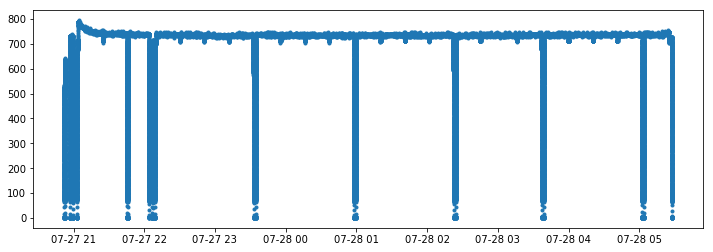

In [3]:
f = AuxService.read_file('20170727.BIAS_CONTROL_CURRENT.fits')
f['Time'] = pd.to_datetime(f.Time, unit='d')
# just for channel 0
plt.figure(figsize=(12, 4))
plt.plot(
    f.Time,
    f.I_0,
    '.'
);

Here now, I loop over all 320 bias channels. I get the entire list of ADC numbers stored, and collapse it channel by channel, to the unique numbers, using the `unique()` function, to make it shorter.
After the loop I collapse the collection of all 320-lists again using the `unique()` function, to make it shorter again.
Then I show you all the numbers

In [4]:
a = []
for i in range(320):
    a.append(f['I_'+str(i)].unique())
unique_numbers = np.unique(np.concatenate(a))
unique_numbers

array([  -4,   -3,   -1,    0,    3,    4,    7,    8,   11,   12,   15,
         16,   19,   20,   23,   24,   27,   28,   31,   32,   35,   36,
         39,   40,   43,   44,   47,   48,   51,   52,   55,   56,   59,
         60,   63,   64,   67,   68,   71,   72,   75,   76,   79,   80,
         83,   84,   87,   88,   91,   92,   95,   96,   99,  100,  103,
        104,  107,  108,  111,  112,  115,  116,  119,  120,  123,  124,
        127,  128,  131,  132,  135,  136,  139,  140,  143,  144,  147,
        148,  151,  152,  155,  156,  159,  160,  163,  164,  167,  168,
        171,  172,  175,  176,  179,  180,  183,  184,  187,  188,  191,
        192,  195,  196,  199,  200,  203,  204,  207,  208,  211,  212,
        215,  216,  219,  220,  223,  224,  227,  228,  231,  232,  235,
        236,  239,  240,  243,  244,  247,  248,  251,  252,  255,  256,
        259,  260,  263,  264,  267,  268,  271,  272,  275,  276,  279,
        280,  283,  284,  287,  288,  291,  292,  2

Now let's have a look, if all the numbers in this is indeed have their two LSBs identical. If the answer is True, I am right.

In [5]:
are_two_least_significant_bits_equal(unique_numbers).all()

False

The answer is `False`... so I am still right :-D. Have you spotted the problem? 

Well, there are negative numbers in this list ... and this ADC does not output negative numbers. These negative numbers are artificially created by `biasctrl.cc` in [line 273](https://trac.fact-project.org/browser/trunk/FACT%2B%2B/src/biasctrl.cc#L270). 

So let's get rid of the negative numbers.

In [6]:
# remove artificial negative ADC codes
unique_numbers = unique_numbers[unique_numbers >= 0]  
are_two_least_significant_bits_equal(unique_numbers).all()

True

## So what now? Do we measure the current wrong or what?

No. Basically all is fine, we calculate the current as if we really had a 12bit 5mA ADC

I = code * 5e-3/4096

but we really have the lowest 11-bit of a 12-bit 10mA ADC, so 

I = (code // 2) * 10e-3/4096

Which is basically the same. 

## So if there is basically nothing we do wrong. Why did you write this lengthy document, and why did I read it???

Well ... it puzzled me for many weeks ... once I thought, we'd measure the current wrong by a factor off two. So I had to dig deeper. I've written this, to prevent others from dumping a similar amount of time into this question.

Basically all to take away from this is: 

** FACT resolution for SiPM current measurement is ~2.4µA **

(The accuracy might be in the same range)